<a href="https://colab.research.google.com/github/Dnbg1982/Oil-Gas-Projects/blob/main/Salt_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TGS Salt Identification KAGGLE

This notebook builds a binary clasification model using TensorFlow. 

## 1. Problem
Differentiate the part of subsurface which is salt.

## 2. Data
The data is a set of images chosen at various locations chosen at random in the subsurface.  

## 3. Evaluation
This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds.

## 4. Features
Some information about data:
* The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. 
* In addition to the seismic images, the depth of the imaged location is provided for each image
* There are 2 classes salts and sediments.
* There are around of 4K images in the training set and 18K in test set as well.





## Import libraries and get environment ready (GPU)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
import os

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from random import *

from IPython.core.display import Image

from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dense, Dropout, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Add, concatenate
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1 import local_variables_initializer
from tensorflow.keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from numpy.ma.core import log
import datetime

%matplotlib inline

## Getting data ready (turning into Tensors)
Tranforming images into numerical data -> Tensors (np.arrays, matrixs, etc).

### Data Exploration

In [16]:
depths_csv = pd.read_csv('drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/depths.csv')
depths_csv.shape

(22000, 2)

In [17]:
train_csv = pd.read_csv('drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train.csv')
train_csv.shape

(4000, 2)

In [18]:
# Define file paths of train images and masks
path_train = 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/images/'
path_masks = 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/masks/'
path_test = 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/test/images/'
 

In [19]:
lst = train_csv['id'][5:11].tolist()
lst

['aae8971d6e',
 'b80db32c01',
 '164873b51f',
 'e335542c17',
 'db840e1e22',
 'a898892737']

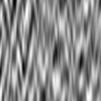

In [20]:
# Load an image and a mask
load_img(path_train + lst[1] + '.png')

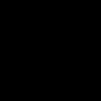

In [21]:
load_img(path_masks + lst[1] + '.png')

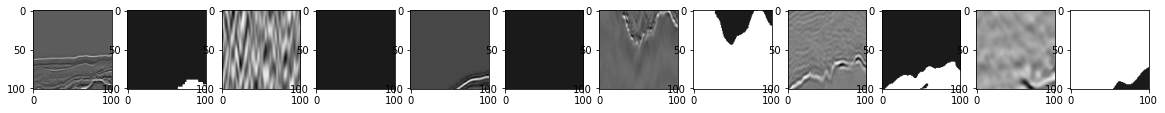

In [22]:
plt.figure(figsize=(20,5))

for id, name in enumerate(lst):
  q = id + 1
  image = load_img(path_train + name + '.png')
  mask = load_img(path_masks + name + '.png')

  plt.subplot(1,len(lst)*2, q*2-1)
  plt.imshow(image)

  plt.subplot(1,len(lst)*2,q*2)
  plt.imshow(mask, alpha = 0.9)

plt.show()

In [23]:
# Gather ids list from the train folder
train_filenames = sorted([path_train + fname for fname in os.listdir(path_train)])
train_filenames[:4]

['drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/images/000e218f21.png',
 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/images/003c477d7c.png',
 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/images/00441f1cf2.png',
 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/images/0050766ae2.png']

In [24]:
# Gather ids list from the mask folder
mask_filenames = sorted([path_masks + fname for fname in os.listdir(path_masks)])
mask_filenames[:4]

['drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/masks/000e218f21.png',
 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/masks/003c477d7c.png',
 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/masks/00441f1cf2.png',
 'drive/MyDrive/Datasets/Tgs-salt-identification/competition_data/train/masks/0050766ae2.png']

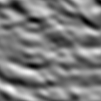

In [25]:
Image(train_filenames[1])

### Preprocessing Images
1. Normalize
2. Transform images into values multiples of 32 

#### 1. Read, decode and normalize data

To normalize the values to range from 0 to 1, amd making the numbers small and the computation easier and faster. As the pixel values range from 0 to 256, therefore dividing all the values by 255 will convert it to range from 0 to 1.

In [26]:
x_tf = [tf.io.read_file(x) for x in train_filenames] # Read files from train directory.
x_tf = [tf.image.decode_png(x, channels=1) for x in x_tf] # Decode images into numbers.
x_tf = (tf.image.convert_image_dtype(x_tf, dtype = tf.uint8) / 255) # Convert images into tensor and normalize dividing by 255.
x_tf.shape

TensorShape([4000, 101, 101, 1])

In [27]:
y_tf = [tf.io.read_file(y) for y in mask_filenames] # Read files from masks directory.
y_tf = [tf.image.decode_png(y, channels=1) for y in y_tf] # Decode images into numbers.
y_tf = (tf.image.convert_image_dtype(y_tf, dtype = tf.uint8) / 255) # Convert images into tensor and normalize dividing by 255.
y_tf.shape

TensorShape([4000, 101, 101, 1])

#### 2. Resize input image. U-net needs multiples of 2 to stabilize. 

In [28]:
size = 128

def resize_image(img, size):
  
  image_m = np.zeros((img.shape[0], size, size, 1))
  
  for i in range(img.shape[0]):
     image_m[i] = resize(img[i],(size, size))
  
  return image_m

In [29]:
x_tf_r = resize_image(x_tf, size=128)
y_tf_r = resize_image(y_tf, size=128)
x_tf_r.shape, y_tf_r.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

In [30]:
x_tf_r[0][:,:,-1].shape

(128, 128)

Plotting the images to check out the data

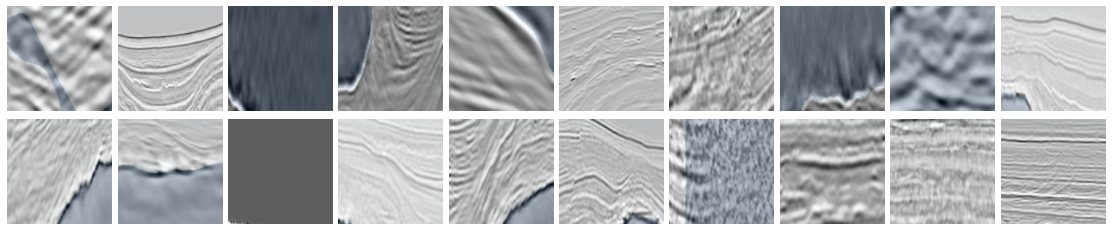

In [169]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20,4))
for i in range(2):
  for j in range(10):
      r_img = randint(0,x_tf_r.shape[0]-1)
      ax[i,j].imshow(x_tf_r[r_img][:,:,-1], cmap='Greys')
      ax[i,j].imshow(y_tf_r[r_img][:,:,-1], cmap='Blues', alpha=0.2)
      ax[i,j].set_axis_off()
  
  fig.subplots_adjust(wspace=-0.1, hspace=0.08)
plt.show()

### Spliting data into training and validation sets

In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(x_tf_r, y_tf_r, test_size=0.2, random_state=82)

In [33]:
X_train.shape, Y_train.shape,X_val.shape, Y_val.shape # Verify shape of sets

((3200, 128, 128, 1),
 (3200, 128, 128, 1),
 (800, 128, 128, 1),
 (800, 128, 128, 1))

It is possible to carry on data augmentation but more computer power is necessary. To do this it is possible to create new images from the existing ones by flipping them.

### Data Augmentation

Model can be improved generating new images from the existing ones by flipping them. However, increase the number of samples will need a lot of computer power.

This model won't take into account this part but the code below show a way to do it.

In [34]:
# x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
# y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
# x_train = np.append(x_train, [np.flipud(x) for x in x_train], axis=0)
# y_train = np.append(y_train, [np.flipud(x) for x in y_train], axis=0)

### Creating the Model

1. Build the model
2. Create metric IOU
3. Fit model with the data
4. Predict on the validation set


#### Build the Keras Model

In [35]:
def unet(input_size=(128, 128, 1)):

  inputs = Input(input_size)

  # 128
  c0 = Conv2D(8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
  c0 = BatchNormalization()(c0)
  c0 = Conv2D(8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c0)
  c0 = BatchNormalization()(c0)
  p0 = MaxPool2D(pool_size=(2,2))(c0)

  # 128 -> 64
  c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p0)
  c1 = BatchNormalization()(c1)
  c1 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPool2D(pool_size=(2,2))(c1)

  # 64 -> 32
  c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPool2D(pool_size=(2,2))(c2)

  # 32 -> 16
  c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPool2D(pool_size=(2,2))(c3)

  # center 16 -> 8
  c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)

  # 8 -> 16
  up5 = Conv2DTranspose(64, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
  up5 = BatchNormalization()(up5)
  m5 = concatenate([up5,c3])
  c5 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(m5)
  c5 = BatchNormalization()(c5)
  c5 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
  c5 = BatchNormalization()(c5)

  # 16 -> 32
  up6 = Conv2DTranspose(32, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
  up6 = BatchNormalization()(up6)
  m6 = concatenate([up6,c2])
  c6 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(m6)
  c6 = BatchNormalization()(c6)
  c6 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
  c6 = BatchNormalization()(c6)
  
  # 32 -> 64
  up7 = Conv2DTranspose(16, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
  up7 = BatchNormalization()(up7)
  m7 = concatenate([up7,c1])
  c7 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(m7)
  c7 = BatchNormalization()(c7)
  c7 = Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
  c7 = BatchNormalization()(c7)

  # 64 -> 128
  up8 = Conv2DTranspose(8, (2,2), strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(c7)
  up8 = BatchNormalization()(up8)
  m8 = concatenate([up8,c0])
  c8 = Conv2D(8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(m8)
  c8 = BatchNormalization()(c8)
  c8 = Conv2D(8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)
  c8 = BatchNormalization()(c8)

  outputs = Conv2D(1,(1,1), padding='same', activation='sigmoid')(c8)
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

#### Scoring Metric IOU

In [36]:
iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)

#### Fit the model

In [37]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  80          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [38]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', iou_metric])

In [39]:
# Load TensorBoard notebook extension
# %load_ext tensorboard 

In [40]:
# Create TensorBoard callback
# def tb_callback():
  # Create a log directory
  #logdir = os.path.join('drive/MyDrive/Datasets/Tgs-salt-identification/logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

  #return tf.keras.callbacks.TensorBoard(logdir)

In [41]:
# Model Callbacks
monitor = 'val_accuracy'
early_stopping = EarlyStopping(monitor=monitor, patience=10, verbose=1)
filepath = 'drive/MyDrive/Datasets/Tgs-salt-identification/keras.model'
model_checkpoint = ModelCheckpoint(filepath, monitor=monitor, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=monitor,factor=0.1, patience=5, min_lr=0.00000005, verbose=1)
#tensorboard = tb_callback()

epochs = 20
batch_size= 32

history = model.fit(X_train, Y_train, validation_data=[X_val, Y_val], epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7884 - mean_io_u: 0.3788
Epoch 1: val_accuracy improved from -inf to 0.30383, saving model to drive/MyDrive/Datasets/Tgs-salt-identification/keras.model
INFO:tensorflow:Assets written to: drive/MyDrive/Datasets/Tgs-salt-identification/keras.model/assets
100/100 [==============================] - 29s 142ms/step - loss: 0.5227 - accuracy: 0.7884 - mean_io_u: 0.3788 - val_loss: 10.9923 - val_accuracy: 0.3038 - val_mean_io_u: 0.4340 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8828 - mean_io_u: 0.3790
Epoch 2: val_accuracy improved from 0.30383 to 0.68903, saving model to drive/MyDrive/Datasets/Tgs-salt-identification/keras.model
INFO:tensorflow:Assets written to: drive/MyDrive/Datasets/Tgs-salt-identification/keras.model/assets
100/100 [==============================] - 13s 131ms/step - loss: 0.3421 - accuracy: 0.8828 - mean_io_u: 0.3790 - v

In [42]:
# Checking the TensorBoard logs
# %tensorboard --logdir drive/MyDrive/Datasets/Tgs-salt-identification/logs

In [43]:
model = load_model(filepath)

#### Plotting Model Performace

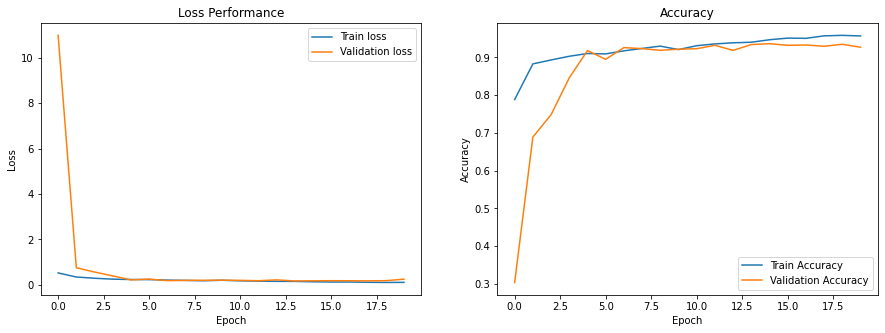

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(history.history['loss'], label="Train loss")
ax1.plot(history.history['val_loss'], label="Validation loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Performance')

ax2.plot(history.history['accuracy'], label="Train Accuracy")
ax2.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend();
ax2.set_title('Accuracy')

plt.show();

#### Predicting on validation set

In [188]:
y_pred = model.predict(X_val)
y_pred.shape

(800, 128, 128, 1)

##### Plotting True Masks vs. Predictions

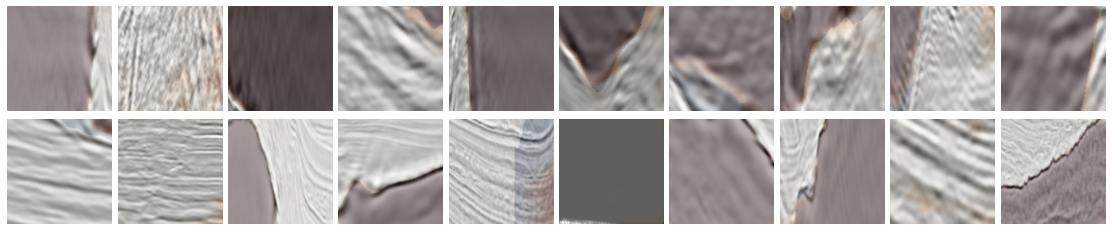

In [170]:
np.random.seed(80)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20,4))
for i in range(2):
  for j in range(10):
      r_img = np.random.randint(0,X_val.shape[0]-1)
      ax[i,j].imshow(X_val[r_img][:,:,-1], cmap='Greys')
      ax[i,j].imshow(Y_val[r_img][:,:,-1], cmap='Blues', alpha=0.2)
      ax[i,j].imshow(y_pred[r_img][:,:,-1], cmap='Oranges', alpha=0.2)
      ax[i,j].set_axis_off()
  
fig.subplots_adjust(wspace=-0.1, hspace=0.08)
plt.show()

### Scoring
Score the model and do a threshold optimization.

In [189]:
# The model can be tune using different thresholds
for t in np.round(np.linspace(0.5,1,5), decimals=1):
  IOU_mean = tf.keras.metrics.MeanIoU(num_classes=2)
  IOU_mean.update_state(Y_val, y_pred > t)
  mean_iou = IOU_mean.result().numpy()
  print(f'Threshold:{t} - Mean_IOU: {mean_iou}')

Threshold:0.5 - Mean_IOU: 0.8546931743621826
Threshold:0.6 - Mean_IOU: 0.8556480407714844
Threshold:0.8 - Mean_IOU: 0.8491916656494141
Threshold:0.9 - Mean_IOU: 0.8381546139717102
Threshold:1.0 - Mean_IOU: 0.3745119273662567


In [165]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [200]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(Y_val, np.int8(y_pred > threshold)) for threshold in thresholds])

In [205]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
threshold_best

0.7959183673469387

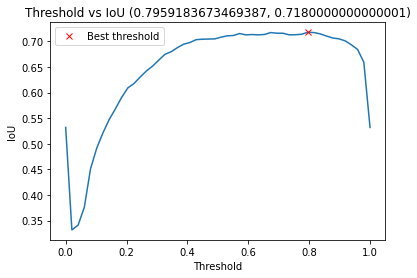

In [206]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

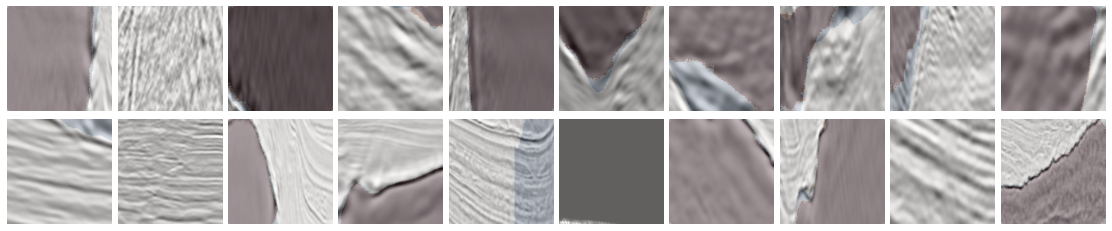

In [207]:
np.random.seed(80)
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20,4))
for i in range(2):
  for j in range(10):
      r_img = np.random.randint(0,X_val.shape[0]-1)
      ax[i,j].imshow(X_val[r_img][:,:,-1], cmap='Greys')
      ax[i,j].imshow(Y_val[r_img][:,:,-1], cmap='Blues', alpha=0.2)
      ax[i,j].imshow(y_pred[r_img][:,:,-1]>threshold_best, cmap='Oranges', alpha=0.2)
      ax[i,j].set_axis_off()
  
fig.subplots_adjust(wspace=-0.1, hspace=0.08)
plt.show()